In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
sns.set()

from tensorflow.keras import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

from chord_functions import *

from sklearn.metrics import *
from sklearn.model_selection import KFold

# Setup

In [2]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)

#Load all data
data = pd.read_csv('data/R10.csv')

#Remove redundant attributes. Need to keep op to split
data = data[['chord', 'op']]

#Tranform the chords using one-hot encoding before separation so train and test have same # of features
data = pd.get_dummies(data)

#Separate one opus for testing purposes
opus = 131
test = data.loc[data['op'] == opus]
train = data.loc[data['op'] != opus]

#Remove the opus feature
test = test.drop(columns='op')
train = train.drop(columns='op')


# Sequence generation

In [3]:
#Create input sequences of length 10, predict the 11:th
seq_length = 10

train_in, train_out = generate_sequences(train, train, seq_length)

test_in, test_out = generate_sequences(test, test, seq_length)

# Model

In [4]:
def lstm(lstm_x, lstm_y, optimizer, loss, metrics):
    model = Sequential()
    
    model.add(LSTM(256, return_sequences=True, input_shape=(lstm_x.shape[1], lstm_x.shape[2])))
    
    model.add(Dropout(0.5))
    
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    
    model.add(LSTM(64, return_sequences=False))
    
    model.add(Dropout(0.3))
    
    model.add(Dense(lstm_y.shape[1], activation='softmax'))

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [5]:
#Define hyperparameters
optimizer = 'Adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']


# Training

### Hyperparameters

In [28]:
cv_folds = 5
epochs = 30
verbose = 1

#Save the weights whenever validation accuracy is increased
checkpoint = ModelCheckpoint(
    'weights.{epoch:02d}-{val_acc:.4f}.hdf5',
    monitor='val_acc', 
    verbose=0,        
    save_best_only=False
)
# Stop the learning process if we havent improved validation accuracy for 10 epochs
earlystop = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1)
callbacks_list = [checkpoint, earlystop]     

### Cross validate

In [29]:
#Set up how to split the data
kf = KFold(n_splits=cv_folds, random_state=seed, shuffle=False)

model_storage = []
current_fold = 1

for train_fold, test_fold in kf.split(train_in):
    
    #Create model
    model = lstm(train_in, train_out, optimizer, loss, metrics)
    
    print("Current fold = {}".format(current_fold))
    current_fold += 1
    
    #Define the training fold
    train_x = train_in[train_fold]
    train_y = train_out[train_fold]
    
    #Define the test fold
    test_x = train_in[test_fold]
    test_y = train_out[test_fold]
    
    #Train on the folds
    model.fit(train_x,
              train_y,
              epochs = epochs,
              verbose = verbose,
              validation_data = (test_x, test_y),
              callbacks = callbacks_list)
    
    #Store the final model objects in a vector, one for each fold
    model_storage.append(model)

Current fold = 1
Train on 20415 samples, validate on 5104 samples
Epoch 1/30
20415/20415 [==============================] - 145s 7ms/step - loss: 3.7237 - acc: 0.1022 - val_loss: 3.6433 - val_acc: 0.1236
Epoch 2/30
20415/20415 [==============================] - 124s 6ms/step - loss: 3.6642 - acc: 0.1063 - val_loss: 3.6337 - val_acc: 0.1236
Epoch 3/30
20415/20415 [==============================] - 119s 6ms/step - loss: 3.6302 - acc: 0.1141 - val_loss: 3.5572 - val_acc: 0.1274
Epoch 4/30
20415/20415 [==============================] - 121s 6ms/step - loss: 3.4909 - acc: 0.1457 - val_loss: 3.4760 - val_acc: 0.1328
Epoch 5/30
20415/20415 [==============================] - 116s 6ms/step - loss: 3.4348 - acc: 0.1556 - val_loss: 3.4239 - val_acc: 0.1420
Epoch 6/30
20415/20415 [==============================] - 115s 6ms/step - loss: 3.3558 - acc: 0.1709 - val_loss: 3.3693 - val_acc: 0.1528
Epoch 7/30
20415/20415 [==============================] - 115s 6ms/step - loss: 3.2948 - acc: 0.1853 - val

20415/20415 [==============================] - 116s 6ms/step - loss: 3.2887 - acc: 0.1818 - val_loss: 3.2647 - val_acc: 0.1810
Epoch 6/30
20415/20415 [==============================] - 116s 6ms/step - loss: 3.2407 - acc: 0.1928 - val_loss: 3.2573 - val_acc: 0.1957
Epoch 7/30
20415/20415 [==============================] - 116s 6ms/step - loss: 3.2016 - acc: 0.2049 - val_loss: 3.2285 - val_acc: 0.2010
Epoch 8/30
20415/20415 [==============================] - 117s 6ms/step - loss: 3.1659 - acc: 0.2153 - val_loss: 3.2196 - val_acc: 0.2122
Epoch 9/30
20415/20415 [==============================] - 116s 6ms/step - loss: 3.1403 - acc: 0.2239 - val_loss: 3.2030 - val_acc: 0.2194
Epoch 10/30
20415/20415 [==============================] - 117s 6ms/step - loss: 3.0937 - acc: 0.2320 - val_loss: 3.1991 - val_acc: 0.2247
Epoch 11/30
20415/20415 [==============================] - 117s 6ms/step - loss: 3.0660 - acc: 0.2369 - val_loss: 3.1937 - val_acc: 0.2249
Epoch 12/30
20415/20415 [==================

# Results

### Best results for each fold:
epoch: 9 - loss: 3.1670 - acc: 0.2149 - val_loss: 3.2956 - val_acc: 0.2053

epoch: 13- loss: 2.9963 - acc: 0.2487 - val_loss: 3.1940 - val_acc: 0.2318

epoch: 15- loss: 3.0065 - acc: 0.2494 - val_loss: 3.2946 - val_acc: 0.1963

epoch: 13- loss: 3.0214 - acc: 0.2434 - val_loss: 3.2292 - val_acc: 0.2136

epoch: 13- loss: 2.9744 - acc: 0.2510 - val_loss: 3.1473 - val_acc: 0.2445

Average:

epoch: 12.6 - loss: 3.0331 - acc: 0.2414 - val_loss: 3.2321 - val_acc: 0.2183

Weights for each model stored in folder cross_fold_weights

### Performance on test data

In [38]:
m1 = load_model('cross_fold_weights/weights.09-0.2053.hdf5')
m2 = load_model('cross_fold_weights/weights.13-0.2136.hdf5')
m3 = load_model('cross_fold_weights/weights.13-0.2318.hdf5')
m4 = load_model('cross_fold_weights/weights.13-0.2445.hdf5')
m5 = load_model('cross_fold_weights/weights.15-0.1963.hdf5')
best_models = [m1, m2, m3, m4, m5]

In [40]:
prob_dist = 0
for model in best_models:   
    # Retrieve the probability distributions for the classes
    prob_dist += model.predict(test_in)
    
# Generate chord predictions from the average probability distribution
predicted = remap(prob_dist/cv_folds, test.columns.values)

# Generate actual from the test
actual = remap(test_out, test.columns.values)

print(classification_report(actual, predicted))

                precision    recall  f1-score   support

  chord_#vii%7       0.00      0.00      0.00         2
   chord_#viio       0.00      0.00      0.00         4
  chord_#viio2       0.00      0.00      0.00        16
 chord_#viio43       0.00      0.00      0.00         6
  chord_#viio6       0.00      0.00      0.00         4
 chord_#viio65       0.00      0.00      0.00        14
  chord_#viio7       0.00      0.00      0.00        19
chord_#viio7/V       0.00      0.00      0.00         6
    chord_.Fr6       0.00      0.00      0.00         1
   chord_.Ger6       0.00      0.00      0.00         8
    chord_.It6       0.00      0.00      0.00         1
    chord_.bII       0.00      0.00      0.00         7
   chord_.bII6       0.00      0.00      0.00         9
   chord_.bIII       0.00      0.00      0.00         1
    chord_.bVI       0.00      0.00      0.00         2
   chord_.bVII       0.00      0.00      0.00         1
  chord_.bVII6       0.00      0.00      0.00  

/home/vidya/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Learning Curves

Final values
acc
0.29713445993693705
valacc
0.19043887147335423
loss
2.766961402797302
valoss
3.3665979969837823



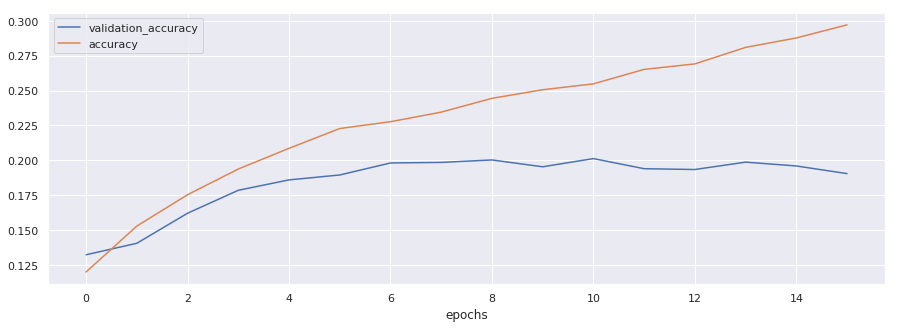

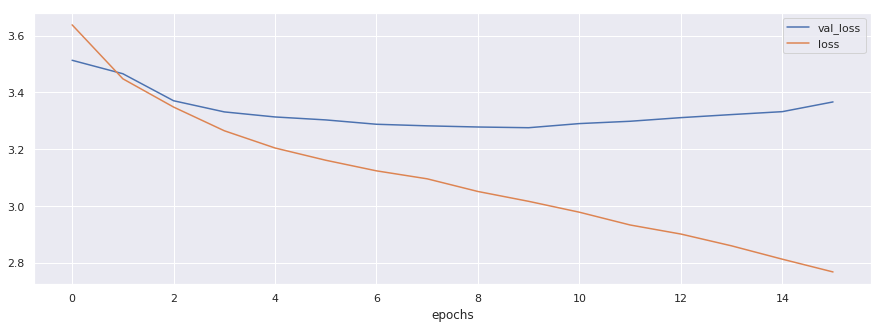

Final values
acc
0.26651971588349654
valacc
0.19435736677115986
loss
2.920108523930576
valoss
3.348575269914346



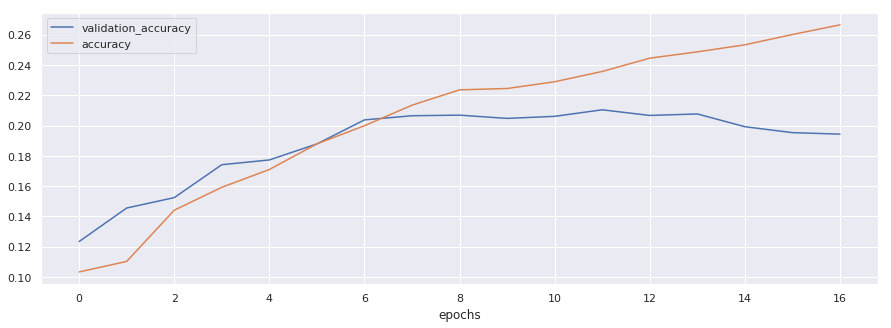

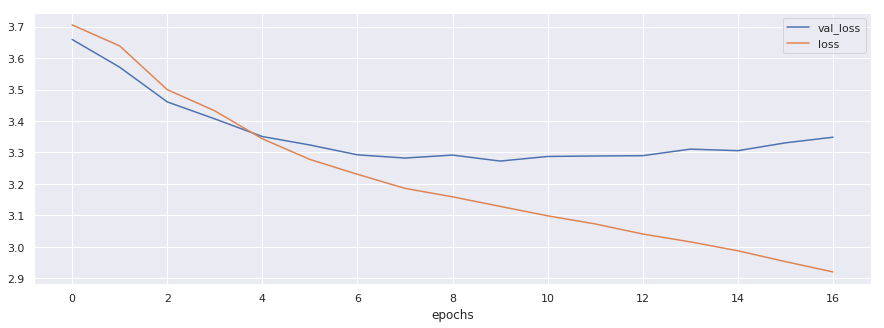

Final values
acc
0.2738182708719563
valacc
0.22727272727272727
loss
2.8739507572632808
valoss
3.2010275487989466



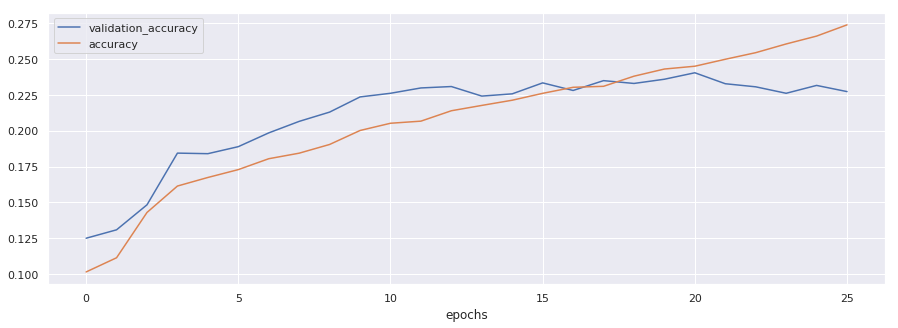

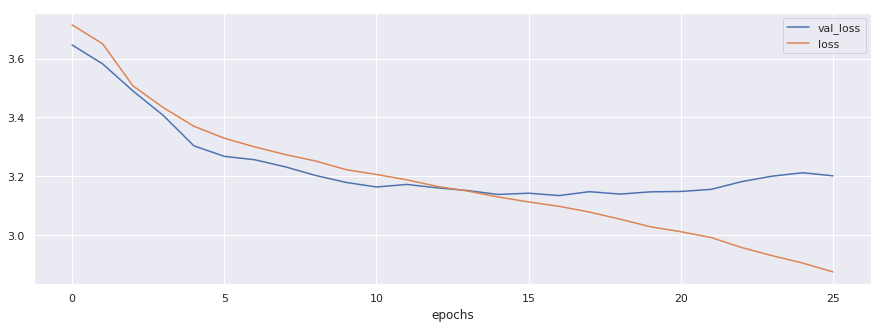

Final values
acc
0.27274063187809866
valacc
0.22315830721003135
loss
2.865606599376098
valoss
3.2887005813443175



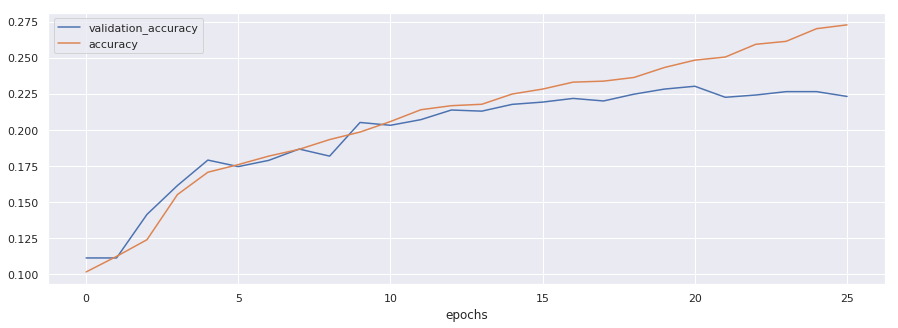

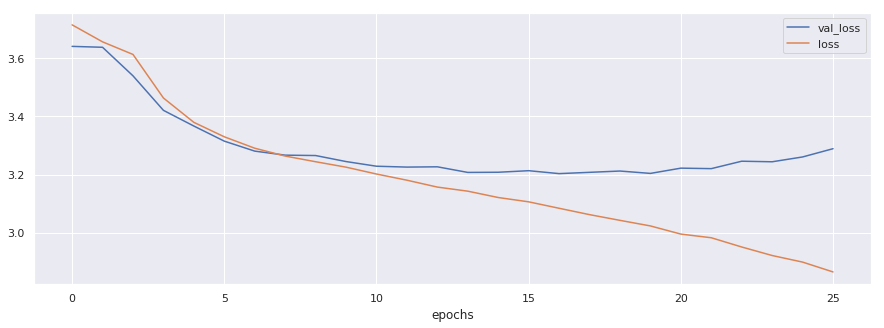

Final values
acc
0.28497257053291536
valacc
0.2057613169133091
loss
2.8159023826025122
valoss
3.3309496668958207



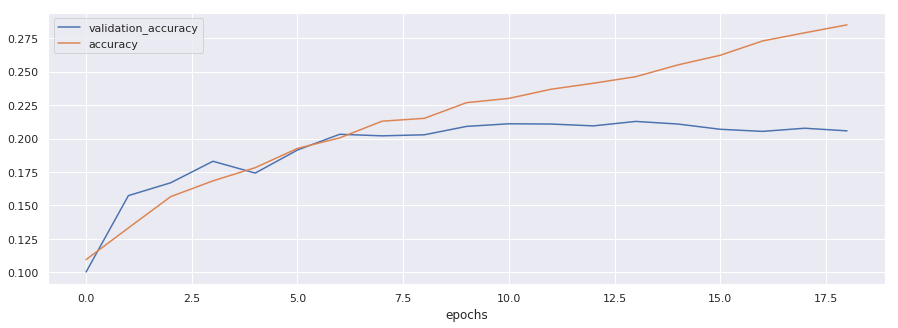

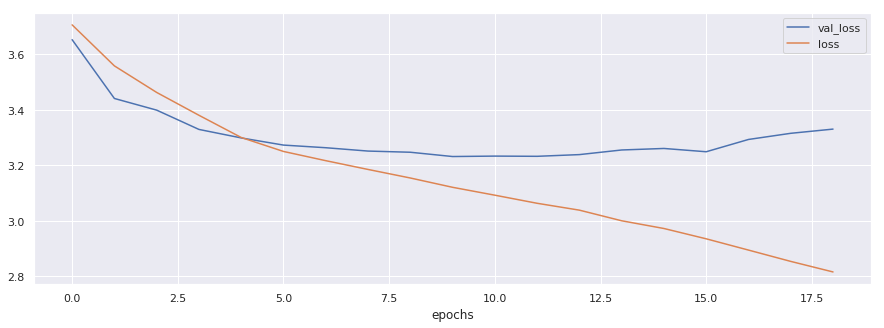

In [11]:
def disp_results(model_vector):
    """
    Takes a model vector plots the evolution of the metrics as well as the final scores for each model
    """
    for model in model_vector:     
        history = model.history
        df = pd.DataFrame({'epochs': history.epoch,
                           'accuracy': history.history['acc'],
                           'validation_accuracy': history.history['val_acc'],
                           'loss': history.history['loss'], 
                           'val_loss': history.history['val_loss']})


        #Plot the the scores on the validation and training sets
        df.plot(x='epochs', y = ['validation_accuracy','accuracy'], figsize=[15,5])
        df.plot(x='epochs', y = ['val_loss','loss'], figsize=[15,5])

        a = history.history['acc'][-1]
        va= history.history['val_acc'][-1]
        l = history.history['loss'][-1]
        vl= history.history['val_loss'][-1]

        print("Final values\nacc\n{}\nvalacc\n{}\nloss\n{}\nvaloss\n{}\n".format(a, va, l, vl))
        plt.show()
    
disp_results(model_storage)

## Confusion Matrix for Predictions

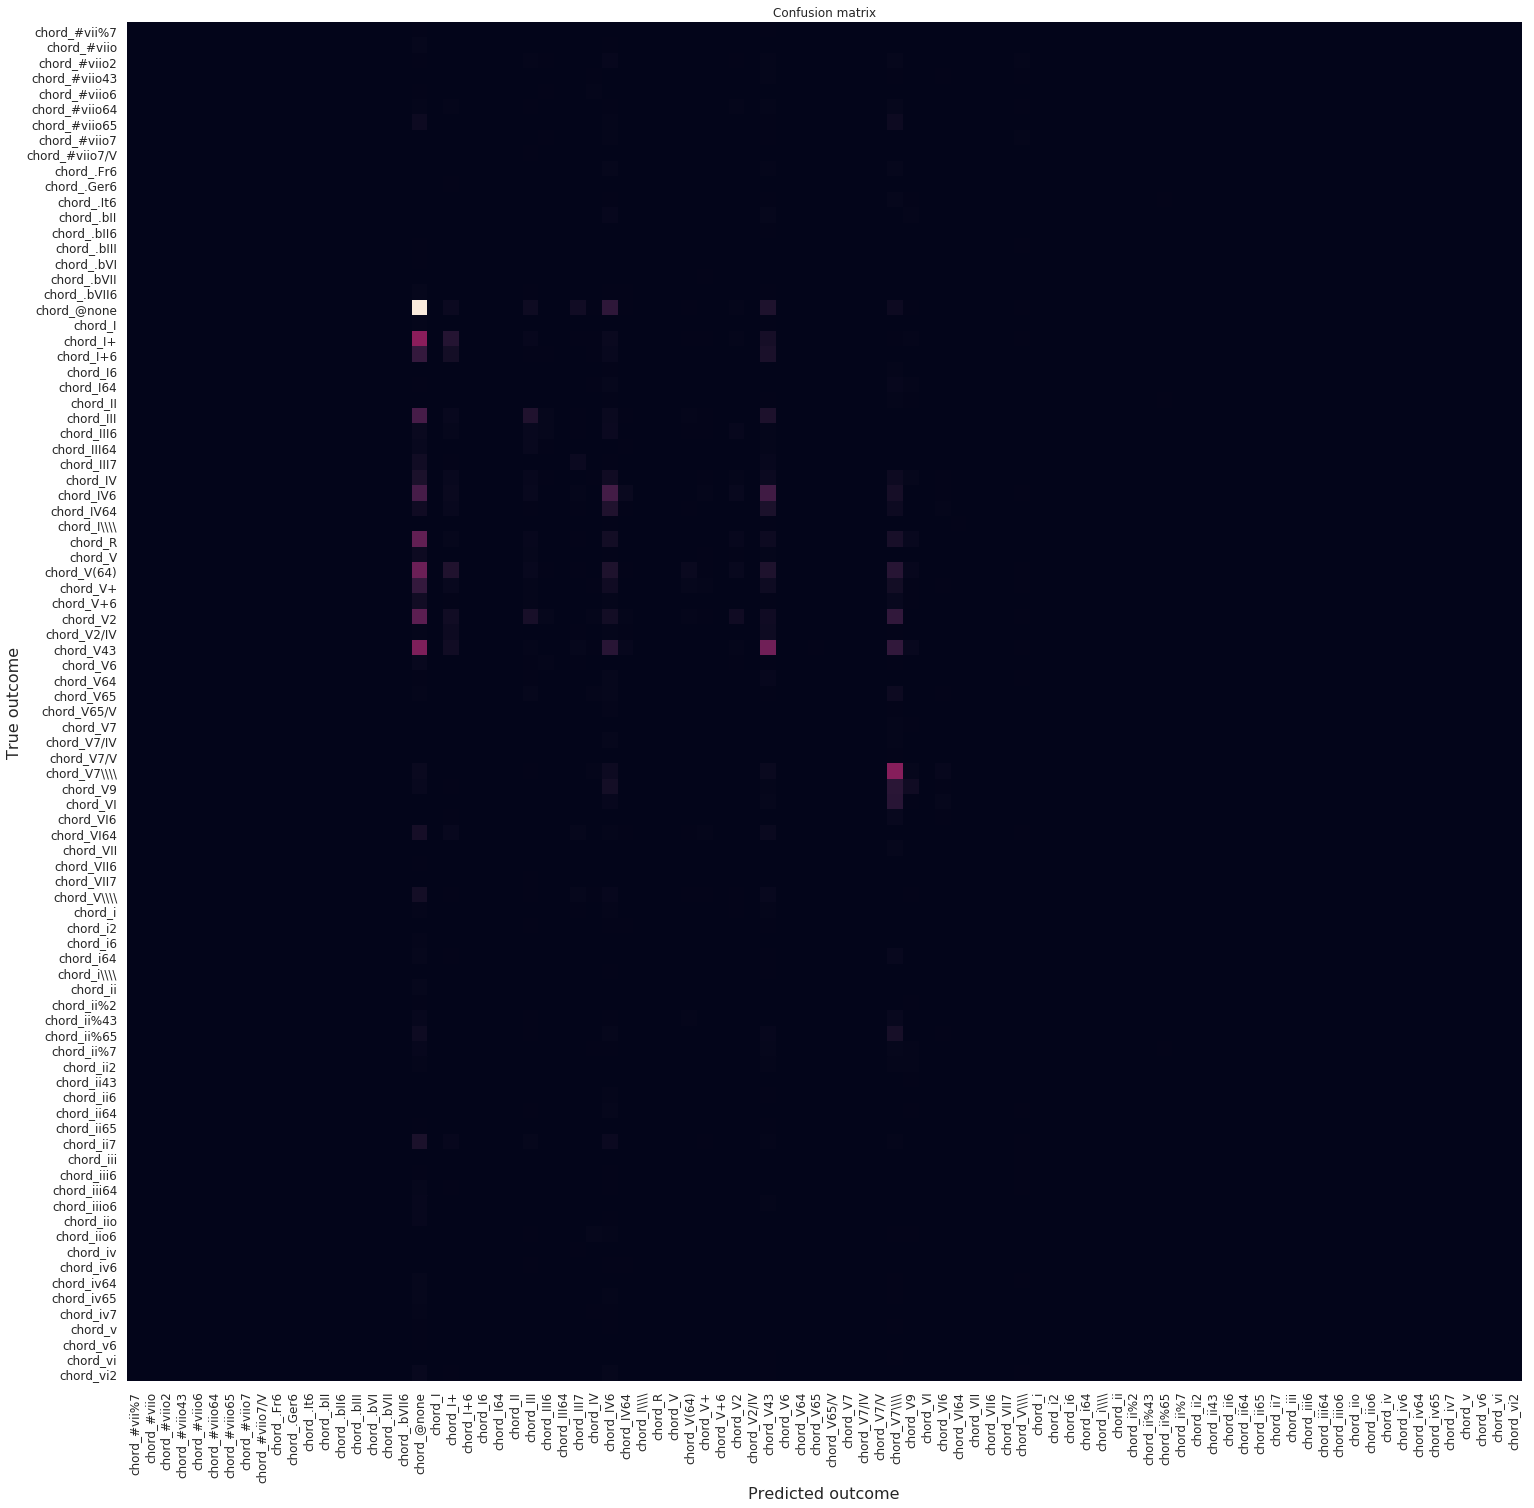

In [41]:
c = confusion_matrix(actual, predicted)

fig, ax = plt.subplots(figsize = (25,25))
sns.heatmap(c, annot=False,  annot_kws={"size": 20}, fmt='d', cbar=False)
ax.set_title('Confusion matrix')
ax.set_xticklabels(test.columns.values, fontsize=12, rotation=90)
ax.set_yticklabels(test.columns.values, fontsize=12, rotation=0)
ax.set_xlabel('Predicted outcome', fontsize=16)
ax.set_ylabel('True outcome', fontsize=16)
plt.show()

## Comparison with human performance